In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn as nn
from sklearn.metrics import f1_score
import seaborn as sns

csv=pd.read_csv("sign_mnist_train.csv")
print(csv.head(10))
labels=csv['label']

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   
5     16     161     168     172     173     178     184     189     193   
6      8     134     134     135     135     136     137     137     138   
7     22     114      42      74      99     104     109     117     127   
8      3     169     174     176     180     183     185     187     188   
9      3     189     189     189     190     190     191     190     190   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     1

In [4]:
import os

In [5]:
text="pixel"
images=torch.zeros((csv.shape[0],1))
for i in range(1,785):
    temp_text=text+str(i)
    temp=csv[temp_text]
    temp=torch.FloatTensor(temp).unsqueeze(1)
    images=torch.cat((images,temp),1)
images_final=torch.FloatTensor(images[:,1:]).view(-1,28,28)

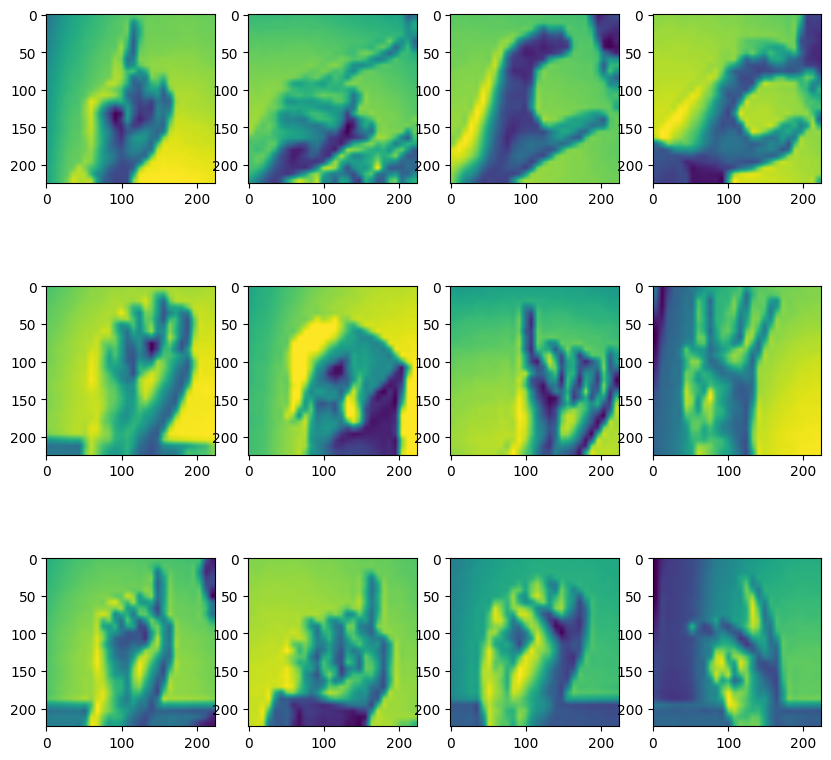

In [6]:
fig=plt.figure(figsize=(10,10))
columns=3
rows=4
for i in range(12):
    img=images_final[i,:]
    img=img.numpy()
    img=cv2.resize(img,(224,224))
    fig.add_subplot(columns, rows, i + 1)
    plt.imshow(img)
plt.show()

In [7]:
class GestureDataset(Dataset):
    def __init__(self,csv,train=True):
        self.csv=pd.read_csv(csv)
        self.img_size=224
        # print(self.csv['image_names'][:5])
        self.train=train
        text="pixel"
        self.images=torch.zeros((self.csv.shape[0],1))
        for i in range(1,785):
            temp_text=text+str(i)
            temp=self.csv[temp_text]
            temp=torch.FloatTensor(temp).unsqueeze(1)
            self.images=torch.cat((self.images,temp),1)
        self.labels=self.csv['label']
        self.images=self.images[:,1:]
        self.images=self.images.view(-1,28,28)

    def __getitem__(self,index):
        img=self.images[index]
        img=img.numpy()
        img=cv2.resize(img,(self.img_size,self.img_size))
        tensor_image=torch.FloatTensor(img)
        tensor_image=tensor_image.unsqueeze(0)
        tensor_image/=255.
        if self.train:
            return tensor_image,self.labels[index]
        else:
            return tensor_image
    def __len__(self):
        return self.images.shape[0]

In [8]:
data=GestureDataset("sign_mnist_train.csv")
data_val=GestureDataset("sign_mnist_train.csv") # Replace with test data when given

In [9]:
train_loader=torch.utils.data.DataLoader(dataset=data,batch_size=128,num_workers=4,shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=data_val,batch_size=64,num_workers=0,shuffle=True)

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.Conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 5), # 220, 220
        nn.MaxPool2d(2), # 110, 110
        nn.ReLU(),
        nn.BatchNorm2d(32)
        )
        self.Conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 5), # 106, 106
        nn.MaxPool2d(2),  # 53,53
        nn.ReLU(),
        nn.BatchNorm2d(64)
        )
        self.Conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3), # 51, 51
        nn.MaxPool2d(2), # 25, 25
        nn.ReLU(),
        nn.BatchNorm2d(128)
        )
        self.Conv4 = nn.Sequential(
        nn.Conv2d(128, 256, 3), # 23, 23
        nn.MaxPool2d(2), # 11, 11
        nn.ReLU(),
        nn.BatchNorm2d(256)
        )
        self.Conv5 = nn.Sequential(
        nn.Conv2d(256, 512, 3), # 9, 9
        nn.MaxPool2d(2), # 4, 4
        nn.ReLU(),
        nn.BatchNorm2d(512)
        )

        self.Linear1 = nn.Linear(512 * 4 * 4, 256)
        self.dropout=nn.Dropout(0.1)
        self.Linear3 = nn.Linear(256, 25)
    def forward(self, x):
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.Conv4(x)
        x=self.dropout(x)
        x = self.Conv5(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.dropout(x)
        x = self.Linear3(x)
        return x

In [11]:
def validate(val_loader,model):
    model.eval()
    test_labels=[0]
    test_pred=[0]
    for i, (images,labels) in enumerate(val_loader):
        outputs=model(images.to(device))
        predicted = torch.softmax(outputs,dim=1)
        _,predicted=torch.max(predicted, 1)
        test_pred.extend(list(predicted.data.cpu().numpy()))
        test_labels.extend(list(labels.data.cpu().numpy()))

    test_pred=np.array(test_pred[1:])
    test_labels=np.array(test_labels[1:])
    correct=(test_pred==test_labels).sum()
    accuracy=correct/len(test_labels)
    f1_test=f1_score(test_labels,test_pred,average='weighted')
    model.train()
    return accuracy,f1_test

In [12]:
model = Classifier()
model.train()
checkpoint = None
device = "cpu"  # Change device to CPU
learning_rate = 1e-3
start_epoch = 0
end_epoch = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True, min_lr=1e-6)

if checkpoint:
    model.load_state_dict(torch.load(checkpoint)['state_dict'])
    start_epoch = torch.load(checkpoint)['epoch']

for epoch in range(start_epoch, end_epoch + 1):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(predicted, 1)
        f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted')

    val_accuracy, val_f1 = validate(val_loader, model)
    print("------------------------------------------------------------------------------------------------------")
    print("Epoch [{}/{}], Training F1: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}".format(epoch, end_epoch, f1, val_accuracy, val_f1))
    scheduler.step(val_accuracy)


c:\Users\vkgat\miniconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
